# COVID-19 Pre-processing Pipeline

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import time
from PIL import Image
import os

In [5]:
NP_SAVE_DIR = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/back_image_np_files"
THERMAL_VID_FILES_DIR = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files"

## Save Numpy Functionality

In [6]:
def save_numpy_file(np_data, filename):
    save_path = os.path.join(NP_SAVE_DIR, filename)
    with open(save_path, 'wb') as f:
        np.save(f, np_data)

## Picking out back frames from a thermal video

In [7]:
def get_back_frames(thermal_np_path):
    back_frame_factor = 0.68
    thermal_width, thermal_height = 384, 288
    thermal_vid = np.load(thermal_np_path)
    num_frame, height_width = thermal_vid.shape
    back_frame = int(0.68 * num_frame)
    thermal_back = np.reshape(thermal_vid[back_frame], (thermal_height, thermal_width))
    
    return thermal_back

We will designate one thermal image as our template and align other thermal images to it using affine registration

In [8]:
thermal_template_path = "/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-08-18_122318.IRS.npy"
thermal_template = get_back_frames(thermal_template_path)

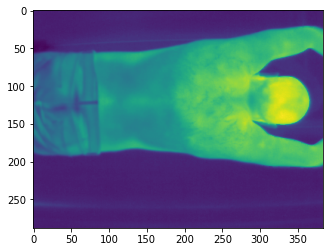

In [9]:
plt.imshow(thermal_template)

We will use the above image as a template for affine registration

## Affine Registration 

In [12]:
import align as al
import align.loss.factory as loss_factory
import align.regularization.factory as regularizer_factory
import SimpleITK as sitk
import torch as th

Within affine registration, parameters that can be toggled in order to achieve better registration are the type of loss function and also the number of iterations. Loss functions include: 
 - mse: Mean Squared Error
 - ncc: Normalized Cross Correlation
 - lcc: Local Normalied Cross Correlation
 - mi: Mutual Information
 - ngf: Normalized Gradient Fields
 - ssim: Structural Similarity Image Measure Loss

From trying different loss functions and visualizing the warped images, I found lcc to work best. I set number of iterations to be 50 because I did not want to overly distort the original image that much. Sometimes, a higher number of iterations results in a very blurred image.

In [152]:
def affine_registration(fixed_image_np, moving_image_np):
    fixed_image = sitk.GetImageFromArray(fixed_image_np)
    moving_image = sitk.GetImageFromArray(moving_image_np)
    fixed_image = al.utils.image_utils.create_tensor_image_from_itk_image(fixed_image)
    moving_image = al.utils.image_utils.create_tensor_image_from_itk_image(moving_image)
    
    normalize_min = min(fixed_image.image.min(), moving_image.image.min())
    normalize_max = max(fixed_image.image.max(), moving_image.image.max()) - normalize_min
    
    fixed_image, moving_image = al.image_filters.normalize_images(fixed_image, moving_image)

    # convert intensities so that the object intensities are 1 and the background 0. This is important in order to
    # calculate the center of mass of the object
    fixed_image.image = 1 - fixed_image.image
    moving_image.image = 1 - moving_image.image

    # create pairwise registration object
    registration = al.registration.PairwiseRegistration(verbose=False)

    # choose the affine transformation model
    transformation = al.transform.transform.SimilarityTransformation(moving_image, opt_cm=True)
    # initialize the translation with the center of mass of the fixed image
    transformation.init_translation(fixed_image)

    registration.set_transformation(transformation)

    image_loss = al.loss.lcc.LCC(fixed_image, moving_image)

    registration.set_image_loss([image_loss])

    # choose the Adam optimizer to minimize the objective
    optimizer = th.optim.Adam(transformation.parameters(), lr=0.01, amsgrad=True)

    registration.set_optimizer(optimizer)
    registration.set_number_of_iterations(50)

    # start the registration
    registration.start()

    # set the intensities back to the original for the visualisation
    fixed_image.image = 1 - fixed_image.image
    moving_image.image = 1 - moving_image.image

    # warp the moving image with the final transformation result
    displacement = transformation.get_displacement()
    warped_image = al.transform.utils.warp_image(moving_image, displacement)
        
    return fixed_image, moving_image, warped_image, normalize_min, normalize_max
        

In [153]:
def plot_affine(fixed_image, moving_image, warped_image):
      # plot the results
        plt.subplot(131)
        plt.imshow(fixed_image.numpy())
        plt.title('Fixed Image')

        plt.subplot(132)
        plt.imshow(moving_image.numpy())
        plt.title('Moving Image')
        
        plt.subplot(133)
        plt.imshow(warped_image.numpy())
        plt.title('Warped Image')
        
        plt.tight_layout()

        plt.show

We need to unnormalize the images so that they have their original temperature values.

In [154]:
def unnormalize_image(image, normalize_max, normalize_min):
    image.image *= normalize_max 
    image.image += normalize_min
    return image

In [255]:
test_thermal = get_back_frames("/Users/jxiang/Dropbox/Covid-Thermal-Images-MIT-Tec/np_files/2020-09-04_122417.IRS.npy")

In [256]:
fixed_image, moving_image, warped_image, normalize_min, normalize_max = affine_registration(thermal_template, test_thermal)

In [257]:
unnormalized_fixed_image = unnormalize_image(fixed_image, normalize_max, normalize_min)
unnormalized_moving_image = unnormalize_image(moving_image, normalize_max, normalize_min)
unnormalized_warped_image = unnormalize_image(warped_image, normalize_max, normalize_min)

Below is an example of a fixed image (template image), moving image (thermal image to be transformed), and the warped image.

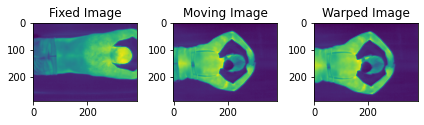

In [258]:
plot_affine(unnormalized_fixed_image, unnormalized_moving_image, unnormalized_warped_image)

## Converting videos to back frame images

In [259]:
def convert_video_to_back_frame(thermal_template_path, thermal_moving_path):
    template_filename = os.path.join(THERMAL_VID_FILES_DIR, thermal_template_path)
    moving_filename = os.path.join(THERMAL_VID_FILES_DIR, thermal_moving_path)
    
    thermal_template = get_back_frames(template_filename)
    thermal_moving = get_back_frames(moving_filename)
    
    plt.imshow(thermal_moving)
    
    fixed_image, moving_image, warped_image, normalize_min, normalize_max = affine_registration(thermal_template, thermal_moving)
    
    unnormalized_warped_image = unnormalize_image(warped_image, normalize_max, normalize_min)
    unnormalized_warped_np = unnormalized_warped_image.numpy()
    
    plot_affine(fixed_image, moving_image, warped_image)
    
    save_numpy_file(unnormalized_warped_np, thermal_moving_path)
    
    

In [260]:
def convert_videos_to_back_frame(thermal_template_path, thermal_images_dir):
    for _,_,files in os.walk(thermal_images_dir):
        for f in files:
            print(f)
            if f.split('.')[-2] == 'IRS':
                convert_video_to_back_frame(thermal_template_path, f)
        

2020-07-30_103207.JPG.npy
2020-07-29_110833.JPG.npy
2020-08-27_133805.IRS.npy
2020-07-23_131937.IRS.npy


/Users/jxiang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jxiang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/Users/jxiang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykern

2020-08-04_120612.JPG.npy
2020-08-05_123608.IRS.npy
2020-07-28_133927.IRS.npy
2020-08-31_183642.IRS.npy
2020-08-11_120902.IRS.npy
2020-08-19_114550.IRS.npy
2020-08-07_122050.IRS.npy
2020-08-24_115646.IRS.npy
2020-07-30_131045.JPG.npy
2020-08-05_122919.IRS.npy
2020-09-04_113531.IRS.npy
2020-08-05_130941.IRS.npy
2020-07-30_102750.JPG.npy
2020-09-01_125133.IRS.npy
2020-08-18_124422.IRS.npy
2020-08-04_114134.IRS.npy
2020-08-07_121006.JPG.npy
2020-08-10_123429.IRS.npy
2020-08-26_141911.IRS.npy
2020-07-30_102600.IRS.npy
2020-08-04_110900.IRS.npy
2020-07-29_115255.IRS.npy
2020-07-20_103413.IRS.npy
2020-08-10_130249.IRS.npy
2020-09-01_131132.IRS.npy
2020-07-29_110541.JPG.npy
2020-07-23_131210.IRS.npy
2020-08-14_125955.IRS.npy
2020-08-04_111418.JPG.npy
2020-08-11_115741.IRS.npy
2020-08-13_123701.IRS.npy
2020-08-24_123809.IRS.npy
2020-09-01_131017.IRS.npy
2020-07-28_121613.IRS.npy
2020-08-07_113639.JPG.npy
2020-08-13_125616.IRS.npy
2020-09-01_133354.IRS.npy
2020-08-19_124136.IRS.npy
2020-08-14_1

2020-08-03_123120.IRS.npy
2020-08-05_130228.JPG.npy
2020-07-30_115636.IRS.npy
2020-08-31_181231.IRS.npy
2020-07-23_140026.IRS.npy
2020-08-12_142820.IRS.npy
2020-08-07_114714.IRS.npy
2020-08-20_120812.IRS.npy
2020-08-26_123458.IRS.npy
2020-07-28_111448.JPG.npy
2020-07-28_111458.JPG.npy
2020-07-30_122252.IRS.npy
2020-08-10_125253.IRS.npy
2020-07-30_112912.JPG.npy
2020-08-14_121508.IRS.npy
2020-08-07_120752.JPG.npy
2020-07-28_133845.JPG.npy
2020-07-30_103950.IRS.npy
2020-08-04_120252.IRS.npy
2020-08-20_121243.IRS.npy
2020-08-07_121204.JPG.npy
2020-07-31_104850.IRS.npy
2020-08-12_123630.IRS.npy
2020-08-05_121849.JPG.npy
2020-08-05_114721.IRS.npy
2020-08-24_132010.IRS.npy
2020-08-05_121919.IRS.npy
2020-07-22_152510.IRS.npy
2020-07-18_204856.JPG.npy
2020-07-29_124901.IRS.npy
2020-08-18_115353.IRS.npy
2020-07-31_112837.JPG.npy
2020-07-28_123049.IRS.npy
2020-07-23_121004.IRS.npy
2020-08-18_122047.IRS.npy
2020-07-30_121809.IRS.npy
2020-08-04_122709.IRS.npy
2020-08-24_135821.IRS.npy
2020-08-05_1

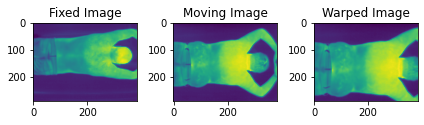

In [261]:
thermal_template_path = "2020-08-18_122318.IRS.npy"
thermal_images_dir = THERMAL_VID_FILES_DIR

convert_videos_to_back_frame(thermal_template_path, thermal_images_dir)

## Sample Points

### Sample Lower Back Point

In [ ]:
def sample_lower_back_point():
    pass

### Sample Upper Back Point

In [70]:
def sample_lower_back_point():
    pass

### Sample Ambient Temperature Point

In [ ]:
def sample_ambient_temperature():
    pass

In [72]:
np.min(warped_image.numpy())

0.0